# Real case verification: the Braunsbach event 

In [1]:
# import rainymotion library
from rainymotion import models, metrics, utils

# import accompanying libraries
from collections import OrderedDict
import numpy as np
import h5py
import matplotlib.pyplot as plt

% matplotlib inline

/home/hydrogo/anaconda3/envs/rainymotion/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data = h5py.File("../data/data.h5", mode="r")
eval_idx = np.load("../data/eval_dict.npy").item()

In [3]:
results = h5py.File("../data/results.h5")

In [4]:
def ground_truth(data_instance, eval_instance, results_instance):
    
    results_instance.create_group("/GT/")
    
    for key in sorted(list(eval_instance.keys())):
               
        ground_truth = np.array([ data_instance[key][()] for key in eval_instance[key][1] ])
        
        results_instance["/GT/"].create_dataset(key, 
                                                data=ground_truth, 
                                                dtype="float16", 
                                                chunks=(12,100,100), 
                                                maxshape=(12,900,900), compression="gzip")

In [5]:
%%time
ground_truth(data, eval_idx, results)

CPU times: user 1min 24s, sys: 382 ms, total: 1min 24s
Wall time: 1min 24s


In [6]:
def persistence(data_instance, eval_instance, results_instance):
    
    results_instance.create_group("/Persistence/")
    
    for key in sorted(list(eval_instance.keys())):
        
        inputs = np.array([ data_instance[key][()] for key in eval_instance[key][0][-1:] ])
        
        model = models.EulerianPersistence()
        
        model.input_data = inputs
        
        nowcast = model.run()
        
        results_instance["/Persistence/"].create_dataset(key,
                                                         data=nowcast, 
                                                         dtype="float16",
                                                         chunks=(12,100,100),
                                                         maxshape=(12,900,900), 
                                                         compression="gzip")

In [7]:
%%time
persistence(data, eval_idx, results)

CPU times: user 56.7 s, sys: 152 ms, total: 56.8 s
Wall time: 57.5 s


In [8]:
def optical_flow(data_instance, eval_instance, results_instance, model_name):
    
    if model_name == "Sparse":
        model = models.Sparse()
    
    elif model_name == "SparseSD":
        model = models.SparseSD()
    
    elif model_name == "Dense":
        model = models.Dense()
    
    elif model_name == "DenseRotation":
        model = models.DenseRotation()
    
    results_instance.create_group("/{}/".format(model_name))
    
    for key in sorted(list(eval_instance.keys())):
        
        inputs = np.array([ data_instance[key][()] for key in eval_instance[key][0] ]).astype("float64")
        
        inputs, a, b = preprocessing.Scaler(inputs)
        
        model.input_data = inputs
        
        nowcast = model.run()
        
        nowcast = preprocessing.inv_Scaler(nowcast, a, b).astype("float16")
        
        results_instance["/{}/".format(model_name)].create_dataset(key, 
                                                                   data=nowcast,
                                                                   dtype="float16",
                                                                   chunks=(12,100,100),
                                                                   maxshape=(12,900,900),
                                                                   compression="gzip")

In [9]:
%%time
optical_flow(data, eval_idx, results, "Sparse")

CPU times: user 7min 23s, sys: 2min 29s, total: 9min 52s
Wall time: 6min 27s


In [10]:
%%time
optical_flow(data, eval_idx, results, "SparseSD")

CPU times: user 6min 32s, sys: 2min 32s, total: 9min 4s
Wall time: 6min 5s


In [11]:
%%time
optical_flow(data, eval_idx, results, "Dense")

CPU times: user 7h 24min 13s, sys: 2h 37s, total: 9h 24min 51s
Wall time: 6h 52min 8s


In [12]:
%%time
optical_flow(data, eval_idx, results, "DenseRotation")

CPU times: user 7h 27min 19s, sys: 2h 23s, total: 9h 27min 43s
Wall time: 6h 55min 45s


In [13]:
def calculate_CSI(obs, sim, thresholds=[0.125, 0.250, 0.500, 1.000]):
    
    result = {}
    
    for threshold in thresholds:
        result[str(threshold)] = [metrics.CSI(obs[i], sim[i], threshold=threshold) for i in range(obs.shape[0])]
    
    return result

def calculate_MAE(obs, sim):
    
    return [metrics.MAE(obs[i], sim[i]) for i in range(obs.shape[0])]

def calculate_metrics_dict(eval_instance, results_instance, 
                           model_names=["Persistence", "Sparse", "SparseSD", "Dense", "DenseRotation"]):
    
    metrics_dict = OrderedDict()
    
    for model_name in model_names:
        
        metrics_dict[model_name] = OrderedDict()
        
        for key in sorted(list(eval_instance.keys())):
            
            metrics_dict[model_name][key] = {model_name: {"CSI": None, "MAE": None}}
            
            o = results_instance["GT"][key][()]
            
            s = results_instance[model_name][key][()]
            
            metrics_dict[model_name][key]["CSI"] = calculate_CSI(o, s)
            metrics_dict[model_name][key]["MAE"] = calculate_MAE(o, s)
    
    return metrics_dict

In [14]:
%%time
metrics_dict = calculate_metrics_dict(eval_idx, results)

CPU times: user 15min 51s, sys: 436 ms, total: 15min 51s
Wall time: 15min 51s


In [15]:
np.save("../data/results_metrics.npy", metrics_dict)

In [5]:
metrics_dict = np.load("../data/results_metrics.npy").item()

In [6]:
def MAE_simple_plot(metrics_dict, ax, axis=0):
    
    ### data preparation block ###
    
    # create a useful keys
    model_names = sorted(list(metrics_dict.keys()))
      
    main_keys = sorted(list(metrics_dict[model_names[0]].keys()))
    
    # create a holder for averaged MAE results
    mae = {model_name: None for model_name in model_names}
    
    for model_name in model_names:
        mae[model_name] = np.array( [metrics_dict[model_name][step]["MAE"] for step in main_keys] )
       
    ###   ###   ###
    t = range(5, 65, 5)
    
    #fig, ax = plt.subplots(figsize=(12, 8))
    
    for model in model_names:
        
        data = mae[model]
        
        data_to_plot = np.mean(data, axis=axis)
        
        ax.plot(t, data_to_plot, label=model)
    
    ax.grid(linestyle="--")
    ax.legend()
    
    ax.set_title("Event starts: {}, ends: {}".format(main_keys[0], main_keys[-1]))
    ax.set_xlabel("Lead time, min")
    ax.set_ylabel("MAE, mm/h")
    
    return ax

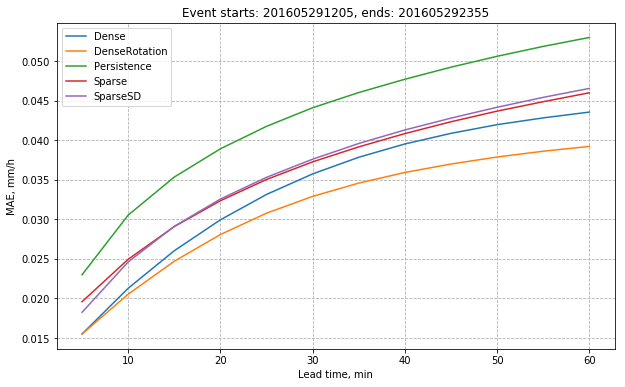

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
ax = MAE_simple_plot(metrics_dict, ax)

In [8]:
def CSI_simple_plot(metrics_dict, threshold, ax):
    
    """
    threshold should be a string from ['0.125', '0.25', '0.5', '1.0']
    """
    
    # create a useful keys
    model_names = sorted(list(metrics_dict.keys()))
    
    main_keys = sorted(list(metrics_dict[model_names[0]].keys()))
    
    # create a holder for averaged MAE results
    csi = {model_name: None for model_name in model_names}
    
    for model_name in model_names:
        csi[model_name] = np.array( [metrics_dict[model_name][step]["CSI"][threshold] for step in main_keys] )
    
    ###
    
    t = range(5, 65, 5)
         
    for model in model_names: 

        data = csi[model]
        data_to_plot = np.mean(data, axis=0)
        ax.plot(t, data_to_plot, label=model)

    ax.grid(linestyle="--")
    ax.legend()
    
    ax.set_title("Event starts: {}, ends: {}, CSI threshold: {}".format(main_keys[0],
                                                                        main_keys[-1],
                                                                        threshold))
    
    ax.set_xlabel("Lead time, min")
    ax.set_ylabel("CSI")

    return ax

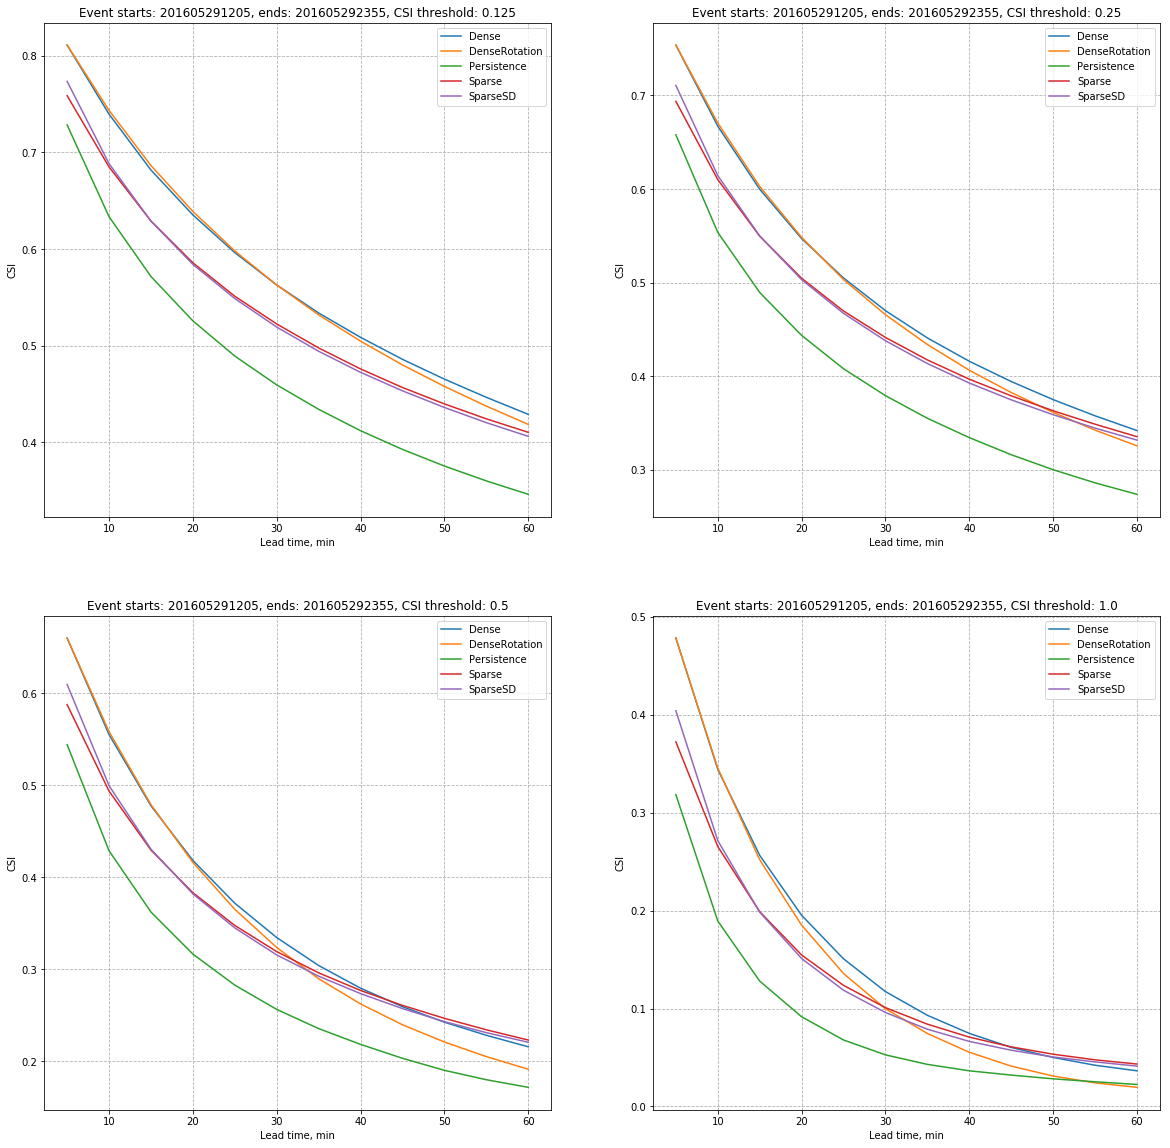

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(20,20))
axes = axes.ravel()
for i, threshold in enumerate(['0.125', '0.25', '0.5', '1.0']):
    axes[i] = CSI_simple_plot(metrics_dict, threshold, axes[i])